In [12]:
import sys
sys.path.insert(0, '../../..')

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.datasets import make_classification, make_moons
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
def evaluate_classification(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    return accuracy, report, confusion

In [ ]:
def plot_decision_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision boundary')

In [ ]:
def plot_data(X, y):
    plt.scatter(X[y==0, 0], X[y==0, 1], color='red', label='Class 0')
    plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class 1')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [2]:
class NeuralNet:
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_1):
        W1 = np.random.randn(n_1, n_x) * 0.01
        b1 = np.zeros((n_1, 1))
        W2 = np.random.randn(1, n_1) * 0.01
        b2 = 0 # у вихідному шарі лише 1 нейрон
        self.parameters = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
       
    def __forward_propagation(self, X):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        Z1 = np.dot(W1, X) + b1
        A1 = self.__sigmoid(Z1)

        Z2 = np.dot(W2, A1) + b2
        A2 = self.__sigmoid(Z2)

        
        cache = (W1, b1, W2, b2, Z1, A1, Z2, A2)

        return A2, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W1, b1, W2, b2, Z1, A1, Z2, A2) = cache
        
        dZ2 = A2 - Y
        dW2 = 1. / m * np.dot(dZ2, A1.T)
        db2 = 1. / m * np.sum(dZ2, axis = 1, keepdims = True)
        
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.multiply(dA1, np.multiply(A1, 1 - A1))
        dW1 = 1. / m * np.dot(dZ1, X.T)
        db1 = 1. / m * np.sum(dZ1, axis = 1, keepdims = True)
        

        grads = {"dZ1" : dZ1, "dW1" : dW1, "db1" : db1, "dZ2" : dZ2, "dW2" : dW2, "db2" : db2}
        return grads
    
    def __update_parameters(self, grads):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        dW1 = grads["dW1"]
        db1 = grads["db1"]
        dW2 = grads["dW2"]
        db2 = grads["db2"]
        

        self.parameters["W1"] = W1 - self.learning_rate * dW1
        self.parameters["b1"] = b1 - self.learning_rate * db1
        self.parameters["W2"] = W2 - self.learning_rate * dW2
        self.parameters["b2"] = b2 - self.learning_rate * db2

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x, 20)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((1 - probs.T, probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 1]
        return (positive_probs >= 0.5).astype(int)  

# Симульовані дані 1

In [ ]:
X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8)
plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet()
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Симульовані дані 2

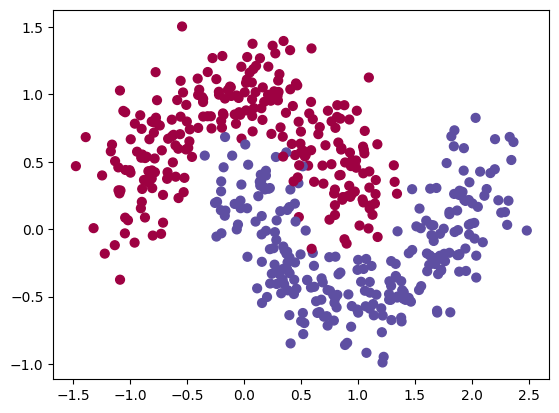

0-th iteration: 0.6930538479278253
1000-th iteration: 0.28204187840488204
2000-th iteration: 0.2810845053680322
3000-th iteration: 0.280649628590799
4000-th iteration: 0.2803890973758718
5000-th iteration: 0.2802082041051684
6000-th iteration: 0.2800710030078545
7000-th iteration: 0.2799601774204603
8000-th iteration: 0.2798654590321792
9000-th iteration: 0.2797790125532338
10000-th iteration: 0.2796918043699039
11000-th iteration: 0.27958399243832893
12000-th iteration: 0.27934936897242924
13000-th iteration: 0.2763230897555294
14000-th iteration: 0.2541933112571234
15000-th iteration: 0.24269304420275034
16000-th iteration: 0.23817667530774578
17000-th iteration: 0.2357970518296451
18000-th iteration: 0.23417321381437897
19000-th iteration: 0.17982193156406404
20000-th iteration: 0.10861507559361247
21000-th iteration: 0.09079355517627341
22000-th iteration: 0.08247657065778309
23000-th iteration: 0.07702514836657068
24000-th iteration: 0.07266600592933752
25000-th iteration: 0.06882

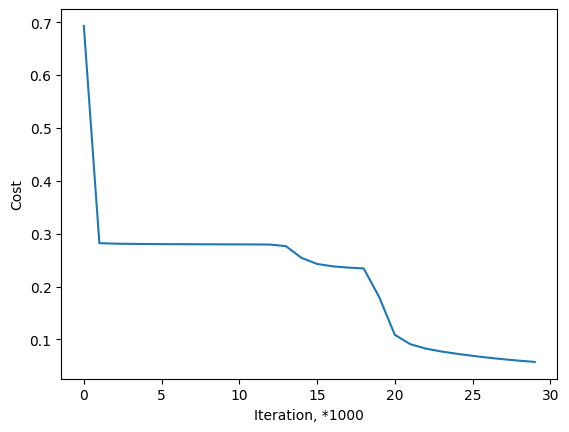

Accuracy: 
0.99
Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.98      0.99        57

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion: 
    0   1
0  43   0
1   1  56


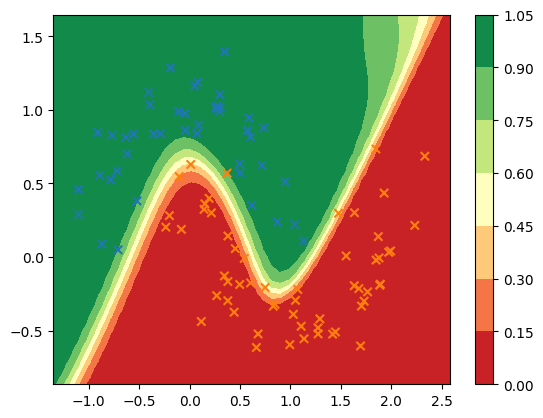

In [122]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet(learning_rate = 0.5)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Tests dataset

In [ ]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column].values

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

0-th iteration: 0.6934105757256838
1000-th iteration: 0.6890144274229468
2000-th iteration: 0.68349740000816
3000-th iteration: 0.6223071066270562
4000-th iteration: 0.610171604677388
5000-th iteration: 0.4414796794861682
6000-th iteration: 0.39005094151496483
7000-th iteration: 0.37448821743229926
8000-th iteration: 0.3551804723707337
9000-th iteration: 0.3449195009229828


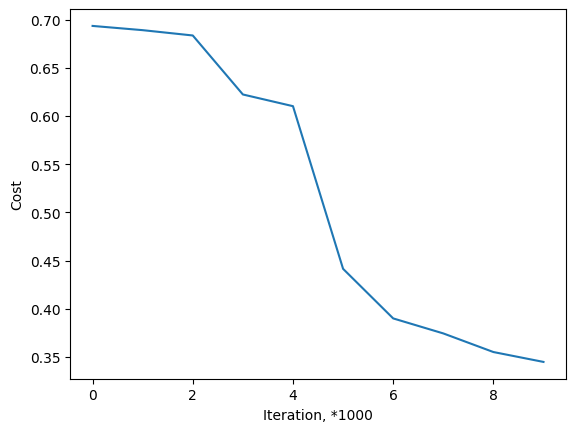

Accuracy: 
0.9166666666666666
Report: 
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      0.83      0.91        12

    accuracy                           0.92        24
   macro avg       0.93      0.92      0.92        24
weighted avg       0.93      0.92      0.92        24

Confusion: 
    0   1
0  12   0
1   2  10


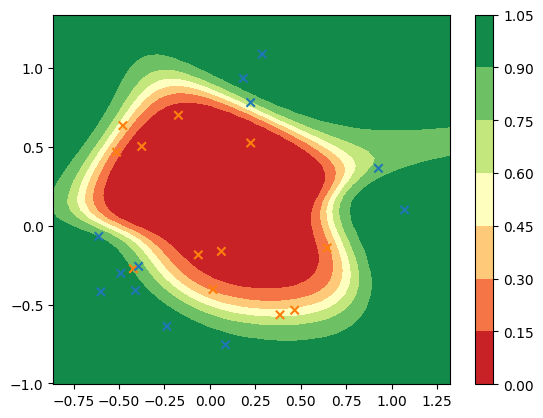

In [124]:
nn = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 10000)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

In [125]:
print(nn.parameters)

{'W1': array([[-1.13276332,  1.07004132],
       [-0.27857601,  0.30156874],
       [-0.06224059,  0.20584996],
       [-1.03317443,  1.77653196],
       [ 0.19517643, -0.25101056],
       [-1.11731771,  1.29857716],
       [ 0.16322781, -2.76586976],
       [-2.60549802, -0.04386901],
       [-0.29202606,  3.41211605],
       [-1.22920003,  0.94948763],
       [ 0.16123422, -0.2307424 ],
       [-2.65880665, -0.51249806],
       [-0.18721372, -1.75433711],
       [-2.10198132, -0.2136792 ],
       [ 0.18699526, -0.25375134],
       [-2.73337129, -1.97332316],
       [ 0.15205146, -0.22232252],
       [-0.17181254,  0.01186793],
       [ 1.29940965, -7.34169378],
       [-1.16383605,  1.26466431]]), 'b1': array([[-1.44557522],
       [-0.02199036],
       [-0.15871322],
       [-1.55395777],
       [-0.20065217],
       [-1.50896358],
       [-4.33118645],
       [-3.45195836],
       [-2.57108154],
       [-1.7202654 ],
       [-0.22044345],
       [-2.36772296],
       [-2.06515763],

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

Accuracy: 
0.8333333333333334
Report: 
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.67      0.80        12

    accuracy                           0.83        24
   macro avg       0.88      0.83      0.83        24
weighted avg       0.88      0.83      0.83        24

Confusion: 
    0  1
0  12  0
1   4  8


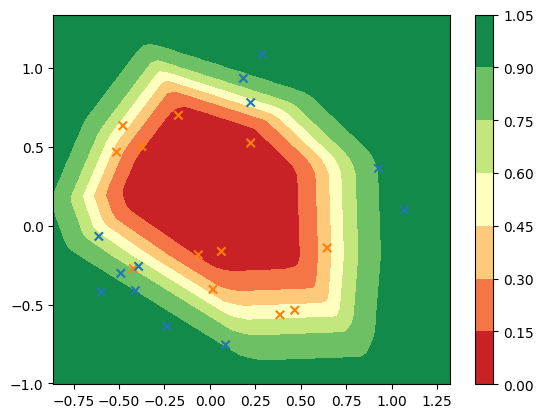

In [126]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

clf.fit(X_train, y_train.ravel())
y_test_pred = clf.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(clf, X_test, y_test)
plt.show()

In [127]:
clf.n_iter_

1754